In [1]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

#!pip install -q datasets seqeval
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import numpy as np
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import torch
import pandas as pd
import re

print("Transformers Version:", transformers.__version__)
print("CUDA Available?", torch.cuda.is_available())
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ✅ Load your data
import pandas as pd
#LOAD EVAL DATASET
#df = pd.read_csv("D:/ML/grok_adddress_parser/grok_address_parser-env/bio_tagged_data_108361_141435_eval.csv")  # Make sure labels are space-separated strings
#df.rename(columns = {'sentence':'text', 'tags':'labels'}, inplace=True)
#df.describe()


d:\ML\grok_adddress_parser\grok_address_parser-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transformers Version: 4.56.0
CUDA Available? False


In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch


# ✅ Load the saved model + tokenizer 
model_path = "D:\ML\grok_adddress_parser\grok_address_parser-env\muril_120k_5epochs"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)
from transformers import pipeline
ner_pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple",device=0)  # 'simple' groups tokens into entities

# Create label mappings
label_list1=['B-APARTMENT', 'B-AREA', 'B-BLOCK', 'B-FLOOR', 'B-HOUSE_NUMBER', 'B-KHASRA_NUMBER', 'B-LANDMARK', 'B-LOCALITY', 'B-LOCALITY2', 'B-PINCODE', 'B-PLOT_NUMBER', 
             'B-ROAD_DETAILS', 'B-VILLAGE', 'I-APARTMENT', 'I-AREA', 'I-BLOCK', 'I-FLOOR', 'I-HOUSE_NUMBER', 'I-KHASRA_NUMBER', 'I-LANDMARK', 'I-LOCALITY', 'I-LOCALITY2',
             'I-PLOT_NUMBER', 'I-ROAD_DETAILS', 'I-VILLAGE', 'O']
#label_list = sorted(set(label for row in df["labels"] for label in row.split()))
label2id = {label: i for i, label in enumerate(label_list1)}
id2label = {i: label for label, i in label2id.items()}
NUM_LABELS = len(label_list1)

print("\n",label_list1)
print("\n",id2label)
print("\n",label2id)

print("\n",NUM_LABELS)
# Map string tags to ID list
#df["label_ids"] = df["labels"].apply(lambda x: [label2id[l] for l in x.split()])
#print(df[["text", "labels", "label_ids"]].head(1))
#df.head()

print(id2label)
model.config.id2label = id2label
model.config.label2id = {v: k for k, v in id2label.items()}
#final_eval = trainer.evaluate()
#print("✅ Final Evaluation:", final_eval)

<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
C:\Windows\Temp\ipykernel_55436\3890445171.py:6: SyntaxWarning: invalid escape sequence '\M'
  model_path = "D:\ML\grok_adddress_parser\grok_address_parser-env\muril_120k_5epochs"
Device set to use cpu



 ['B-APARTMENT', 'B-AREA', 'B-BLOCK', 'B-FLOOR', 'B-HOUSE_NUMBER', 'B-KHASRA_NUMBER', 'B-LANDMARK', 'B-LOCALITY', 'B-LOCALITY2', 'B-PINCODE', 'B-PLOT_NUMBER', 'B-ROAD_DETAILS', 'B-VILLAGE', 'I-APARTMENT', 'I-AREA', 'I-BLOCK', 'I-FLOOR', 'I-HOUSE_NUMBER', 'I-KHASRA_NUMBER', 'I-LANDMARK', 'I-LOCALITY', 'I-LOCALITY2', 'I-PLOT_NUMBER', 'I-ROAD_DETAILS', 'I-VILLAGE', 'O']

 {0: 'B-APARTMENT', 1: 'B-AREA', 2: 'B-BLOCK', 3: 'B-FLOOR', 4: 'B-HOUSE_NUMBER', 5: 'B-KHASRA_NUMBER', 6: 'B-LANDMARK', 7: 'B-LOCALITY', 8: 'B-LOCALITY2', 9: 'B-PINCODE', 10: 'B-PLOT_NUMBER', 11: 'B-ROAD_DETAILS', 12: 'B-VILLAGE', 13: 'I-APARTMENT', 14: 'I-AREA', 15: 'I-BLOCK', 16: 'I-FLOOR', 17: 'I-HOUSE_NUMBER', 18: 'I-KHASRA_NUMBER', 19: 'I-LANDMARK', 20: 'I-LOCALITY', 21: 'I-LOCALITY2', 22: 'I-PLOT_NUMBER', 23: 'I-ROAD_DETAILS', 24: 'I-VILLAGE', 25: 'O'}

 {'B-APARTMENT': 0, 'B-AREA': 1, 'B-BLOCK': 2, 'B-FLOOR': 3, 'B-HOUSE_NUMBER': 4, 'B-KHASRA_NUMBER': 5, 'B-LANDMARK': 6, 'B-LOCALITY': 7, 'B-LOCALITY2': 8, 'B-PINC

In [ ]:
import re

def standardize_address_abbreviations_enhanced(address_text):
    """
    Standardizes common abbreviations in an an address string, with enhanced
    handling for house numbers where abbreviations might be merged with digits.
    """
    if not isinstance(address_text, str):
        return address_text # Return as is if not a string (e.g., None, NaN)

    address_text = address_text.lower() # Convert to lowercase for consistent matching

    # --- NEW Step 0: General Cleaning and Space Introduction ---

    # 0.1: Replace hyphens and slashes with spaces
    address_text = re.sub(r'[-/]', ' ', address_text)

    # 0.2: Introduce a space when switching from an alphabet to a number (e.g., "A123" -> "A 123")
    address_text = re.sub(r'([a-z])(\d)', r'\1 \2', address_text)

    # 0.3: Introduce a space when switching from a number to an alphabet (e.g., "123A" -> "123 A")
    address_text = re.sub(r'(\d)([a-z])', r'\1 \2', address_text)

    # 0.4: Normalize multiple spaces to a single space, and strip leading/trailing spaces
    address_text = re.sub(r'\s+', ' ', address_text).strip()

    # --- Previous Step 1: Pre-process specific merged abbreviations (now less critical but still useful) ---
    # These specific regex patterns might still catch nuanced cases not covered by generic alpha-numeric split.
    # House Number patterns
    address_text = re.sub(r'\b(h|house|hn|hno|no|prop no|flat no|unit no|bldg no|room no|ro)\s*(\d+[a-z]*)\b', r'\1 \2', address_text)
    address_text = re.sub(r'(no|h no|h\.no|h-no)\s*(\d+([a-z])?)', r'\1 \2', address_text)
    address_text = re.sub(r'(house no|hse no)\s*(\d+([a-z])?)', r'\1 \2', address_text)
    address_text = re.sub(r'(prop no)\s*(\d+([a-z])?)', r'\1 \2', address_text)
    address_text = re.sub(r'(bldg no)\s*(\d+([a-z])?)', r'\1 \2', address_text)
    address_text = re.sub(r'(flat no)\s*(\d+([a-z])?)', r'\1 \2', address_text)
    address_text = re.sub(r'(room no|ro)\s*(\d+([a-z])?)', r'\1 \2', address_text)


    # Gali Number patterns
    address_text = re.sub(r'\b(g|gali|gali no|g no)\s*(\d+[a-z]*)\b', r'\1 \2', address_text)
    address_text = re.sub(r'(gali no|g no)\s*(\d+([a-z])?)', r'\1 \2', address_text)
    address_text = re.sub(r'(gali|g)\s*(\d+([a-z])?)', r'\1 \2', address_text)

    # --- Step 2: Define and apply comprehensive word-boundary based replacements ---
    FUZZY_MAP = {
        r'\bhn\b': 'house number',
        r'\bh no\b': 'house number',
        r'\bhouse no\b': 'house number',
        r'\bhse no\b': 'house number',
        r'\bhs no\b': 'house number',
        r'\bhno\b': 'house number',
        r'\bprop no\b': 'property number',
        r'\bflat no\b': 'flat number',
        r'\bunit no\b': 'unit number',
        r'\bkh no\b': 'khasra number',
        r'\bkhasra no\b': 'khasra number',
        r'\bkhno\b': 'khasra number',
        r'\bkhn\b': 'khasra number',


        r'\bg no\b': 'gali number',
        r'\bgali no\b': 'gali number',
        r'\bgno\b': 'gali number',
        r'\bgn\b': 'gali number',

        r'\bpno\b': 'plot number',

        r'\bextn\b': 'extension',
        r'\bext\b': 'extension',
        r'\bextnti\b': 'extension',
        

        r'\bngr\b': 'nagar',


        r'\bph\b': 'phase',
        r'\bphs\b': 'phase',
        r'\bphase no\b': 'phase number',

        r'\bro\b': 'room',
        r'\brm\b': 'room',
        r'\broom no\b': 'room number',


        r'\brd\b': 'road',
        r'\brod\b': 'road',
        r'\bmarg\b': 'road',
        r'\bst\b': 'street',
        r'\bsq\b': 'square',

        r'\bldg\b': 'building',
        r'\bbldg no\b': 'building number',
        r'\bblk\b': 'block',
        r'\bbl\b': 'block',

        r'\bapp\b': 'apartment',
        r'\bapt\b': 'apartment',
        r'\bfl\b': 'floor',
        r'\bgr fl\b': 'ground floor',
        r'\b1st fl\b': 'first floor',
        r'\b2nd fl\b': 'second floor',
        r'\b3rd fl\b': 'third floor',

        r'\blc\b': 'locality',
        r'\barea\b': 'area',
        r'\bpincode\b': 'pincode',
        r'\bpin code\b': 'pincode',

        r'\bnr\b': 'near',
        r'\bopp\b': 'opposite',
        r'\bop\b': 'opposite',
        r'\b(no)\b': 'number', # General 'no' at the end, if not caught by specific patterns
    }

    # Sort keys by length (descending) to ensure longer, more specific matches are attempted first.
    sorted_fuzzy_map_keys = sorted(FUZZY_MAP.keys(), key=len, reverse=True)

    for abbr_pattern in sorted_fuzzy_map_keys:
        full_form = FUZZY_MAP[abbr_pattern]
        address_text = re.sub(abbr_pattern, full_form, address_text)

    # Clean up multiple spaces that might result from replacements
    address_text = re.sub(r'\s+', ' ', address_text).strip()
    return address_text

import pandas as pd
#Assuming df is your DataFrame with an 'address' column
main_df=pd.read_csv("D:\ML\grok_adddress_parser\grok_address_parser-env\exp1.csv")#add path to your dataset that contains address column and division column

# Separate data by division, here we are making seperate clusters in each division thus we diviided the dataframe earlier 
df_d1 = main_df[main_df['Division'] == 'D1'].copy()
df_d2 = main_df[main_df['Division'] == 'D2'].copy()

df_d1['CUSTADDR'] = df_d1['CUSTADDR'].apply(standardize_address_abbreviations_enhanced)
df_d2['CUSTADDR'] = df_d2['CUSTADDR'].apply(standardize_address_abbreviations_enhanced)
print(df_d1.head(10))
print(df_d2.head(10))
print(df_d2.describe())
print(df_d1.describe())
#df_standardized.to_csv("standardized_address_regex_based2.csv", index=False)

<>:128: SyntaxWarning: invalid escape sequence '\M'
<>:128: SyntaxWarning: invalid escape sequence '\M'
C:\Windows\Temp\ipykernel_55436\4055270440.py:128: SyntaxWarning: invalid escape sequence '\M'
  main_df=pd.read_csv("D:\ML\grok_adddress_parser\grok_address_parser-env\exp1.csv")


     ID Division                                           CUSTADDR
0   CA1       D1             j 3 118 j laxmi nagar extension 110092
1   CA2       D1             j 3 163 laxmi nagar j extension 110092
2   CA3       D1             f 86 a jawahar park laxmi nagar 110092
3   CA4       D1                           i 186 laxmi nagar 110092
4   CA5       D1  house number 5 195 lalita park laxmi nagar 110092
5   CA6       D1                            i 34 laxmi nagar 110092
6   CA7       D1           10 a vishwakarma park laxmi nagar 110092
7   CA8       D1       18 1 g f vishwakarma park laxmi nagar 110092
8   CA9       D1            7 a vishwakarma park laxmi nagar 110092
9  CA10       D1                         i 173 a laxmi nagar 110092
      ID Division                                  CUSTADDR
73  CA74       D2  harijan basti tukmir pur shahdara 110094
74  CA75       D2           vill tukmir pur shahdara 110094
87  CA88       D2        vill khajoori khas shahdara 110094
88  CA89    

In [ ]:

from tqdm import tqdm
def batched_ner_out(raw_addresses):
    raw_addresses = raw_addresses.tolist()
    #print(raw_addresses)
    print(label_list1)

    # Predict in batches (not all at once)
    batch_results = []
    for chunk in tqdm(range(0, len(raw_addresses),64)):
        batch = raw_addresses[chunk:chunk+64]
        batch_results.extend(ner_pipe(batch))
    print('batch results',batch_results)
    return batch_results

ner_df1=batched_ner_out(df_d1['CUSTADDR']) 
ner_df2=batched_ner_out(df_d2['CUSTADDR'])
#ner_df2.head(2)
print(ner_pipe("House No. 17-B, Plot No. 45, Old Plot No. 22, Third Floor, Gali No. 4, Street No. 2, Mohalla Shyam Nagar, Main Road, KH No. 78/3/2, B Block, Shyam Residency Apartment, Near Shiv Mandir, Shyam Nagar, Laxmi Nagar, Patparganj Village, Delhi - 110092"))

['B-APARTMENT', 'B-AREA', 'B-BLOCK', 'B-FLOOR', 'B-HOUSE_NUMBER', 'B-KHASRA_NUMBER', 'B-LANDMARK', 'B-LOCALITY', 'B-LOCALITY2', 'B-PINCODE', 'B-PLOT_NUMBER', 'B-ROAD_DETAILS', 'B-VILLAGE', 'I-APARTMENT', 'I-AREA', 'I-BLOCK', 'I-FLOOR', 'I-HOUSE_NUMBER', 'I-KHASRA_NUMBER', 'I-LANDMARK', 'I-LOCALITY', 'I-LOCALITY2', 'I-PLOT_NUMBER', 'I-ROAD_DETAILS', 'I-VILLAGE', 'O']


100%|██████████| 3361/3361 [1:38:40<00:00,  1.76s/it]  


In [ ]:
import pandas as pd
from collections import defaultdict

# ✏️ 1) Edit this list if you add / drop labels later
FIELDS = [
    "HOUSE_NUMBER", "PLOT_NUMBER", "FLOOR", "ROAD_DETAILS", "KHASRA_NUMBER",
    "BLOCK", "APARTMENT", "LANDMARK", "LOCALITY", "AREA", "LOCALITY2",
    "VILLAGE", "PINCODE"
]

# 🔧 2) Utility to stitch sub‑words: "##no" → "no" (attach to previous token)
def join_word(prev, cur):
    if cur.startswith("##"):
        return prev + cur[2:]        # no space, drop ##
    if prev.endswith("-") or prev.endswith("/"):
        return prev + cur            # e.g. "23/" + "A"
    if prev:                         # normal case: add a space
        return prev + " " + cur
    return cur                       # first token

# 🏗️ 3) Convert one NER output list → dict of fields
def convert_single_output(entity_list):
    row = defaultdict(str)

    for ent in entity_list:
        key  = ent["entity_group"]
        word = ent["word"]
        if row[key]:
            row[key] = join_word(row[key], word)
        else:
            row[key] = word.lstrip("##")  # first token

    # 🌐 Compose complete address (simple comma join)
    ordered_parts = [row[f] for f in FIELDS if row[f]]
    if row["PINCODE"]:
        ordered_parts.append(f"Delhi -{row['PINCODE']}")   
    row["complete_address"] = ", ".join(ordered_parts)

    return row

# 🚀 4) Run on your whole batch_results list
parsed_rows = [convert_single_output(addr_entities) for addr_entities in ner_df1]
df1 = pd.DataFrame(parsed_rows)
parsed_rows = [convert_single_output(addr_entities) for addr_entities in ner_df2]
df2 = pd.DataFrame(parsed_rows)

# 🔖 5) Re‑order columns and save
df1= df1[FIELDS + ["complete_address"]]
df_d1 = pd.concat([df1, df_d1], axis=0, ignore_index=True)

df2= df2[FIELDS + ["complete_address"]]
df_d2 = pd.concat([df2, df_d2], axis=0, ignore_index=True)
#df.to_csv("parsed_normalized_address.csv", index=False)

print("added parsed addresses to the original df")
print(df_d1.head())
print(df_d2.head())


---------------------------------------------------------------------------------
fiased based hierachial clustering approach but wiht my murils encoder layer embeddings
partially works

In [ ]:



from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import numpy as np # For numerical operations

# ✅ Load the saved model + tokenizer
model_path = "D:\ML\grok_adddress_parser\grok_address_parser-env\muril_120k_5epochs"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set model to evaluation mode (disables dropout, etc.)

# --- Function to get embeddings ---
def get_sentence_embedding(text, model, tokenizer, device):
    """
    Generates a sentence embedding for a given text using the fine-tuned MURIL model.
    We use the [CLS] token embedding from the last hidden states as the sentence representation.
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad(): # Disable gradient calculation for inference
        # Get outputs without the classification head
        outputs = model(**inputs, output_hidden_states=True)

    # The last hidden state contains embeddings from the BERT encoder
    # outputs.hidden_states is a tuple, last element is the last layer's hidden states
    last_hidden_states = outputs.hidden_states[-1]

    # Typically, the embedding of the [CLS] token (first token) is used as the sentence embedding.
    # You can also consider mean-pooling all token embeddings for the sentence.
    # For address data, [CLS] token embedding is a common choice.
    cls_embedding = last_hidden_states[:, 0, :].squeeze() # Take [CLS] token (index 0) embedding

    return cls_embedding.cpu().numpy() # Move to CPU and convert to NumPy array

# --- Example Usage ---
address_texts = [
    "J - 3 / 118 - J , Laxmi Nagar Extension , Delhi - 110092",
    "J - 3 / 163 , Laxmi Nagar J Extension , Delhi - 110092",
    "G - 5 / 58 , GALI NO - 1 , SONIA VIHAR , Delhi - 110094",
    "D - 17 , GALI - 13 , PREM VIHAR , SHIV VIHAR KARAWAL NAGAR , Delhi - 110094",
    "A-4 Shalimar Garden",
    "A-4 Shalimar Garden Extension",
    "H No - 5 / 195 , Lalita Park , Laxmi Nagar , Delhi - 110092"
]

all_embeddings = []
print("Generating embeddings for addresses...")
for text in address_texts:
    embedding = get_sentence_embedding(text, model, tokenizer, device)
    all_embeddings.append(embedding)

embeddings_array = np.array(all_embeddings)
print(f"Generated embeddings shape: {embeddings_array.shape}") # (num_addresses, embedding_dim)
print(f"Example embedding for '{address_texts[0]}':\n{embeddings_array[0][:10]}...") # Print first 10 dimensions

<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
C:\Windows\Temp\ipykernel_23808\4147316658.py:6: SyntaxWarning: invalid escape sequence '\M'
  model_path = "D:\ML\grok_adddress_parser\grok_address_parser-env\muril_120k_5epochs"
d:\ML\grok_adddress_parser\grok_address_parser-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating embeddings for addresses...
Generated embeddings shape: (7, 768)
Example embedding for 'J - 3 / 118 - J , Laxmi Nagar Extension , Delhi - 110092':
[ 0.00938649  0.05698579 -0.0980868   0.02605196 -0.10472456  0.02071202
 -0.03488051 -0.03788073 -0.0597924  -0.03322206]...


In [2]:
import faiss

# Ensure embeddings are float32, as Faiss typically prefers it
embeddings_array = embeddings_array.astype('float32')
embedding_dim = embeddings_array.shape[1]

# Create a Faiss index
# IndexFlatL2: Simple L2 (Euclidean) distance, exact search. Good for smaller sets or when high precision is critical.
# For very large datasets (millions+), you'd use approximate indexes like IndexIVFFlat or IndexHNSW.
index = faiss.IndexFlatL2(embedding_dim)

# Add your embeddings to the index
index.add(embeddings_array)

print(f"Number of vectors in the Faiss index: {index.ntotal}")

# Find the 5 nearest neighbors for the first address
D, I = index.search(embeddings_array[:1], k=5)
# D: Distances (L2 distance), I: Indices of nearest neighbors
print("\nNearest neighbors for the first address:")
print(f"Distances: {D}")
print(f"Indices: {I}")

Number of vectors in the Faiss index: 7

Nearest neighbors for the first address:
Distances: [[0.         0.00386813 0.00546896 0.02231091 0.04010084]]
Indices: [[0 6 1 3 5]]



Calculating cosine similarity matrix for embeddings...
Diagonal of distance matrix set to zero.

Linkage matrix (Z) created successfully.
First 5 rows of Z_embeddings:
 [[0.00000000e+00 6.00000000e+00 9.82403755e-04 2.00000000e+00]
 [1.00000000e+00 7.00000000e+00 1.99000075e-03 3.00000000e+00]
 [4.00000000e+00 5.00000000e+00 2.95031071e-03 2.00000000e+00]
 [2.00000000e+00 3.00000000e+00 4.40824032e-03 2.00000000e+00]
 [8.00000000e+00 1.00000000e+01 1.13768855e-02 5.00000000e+00]]


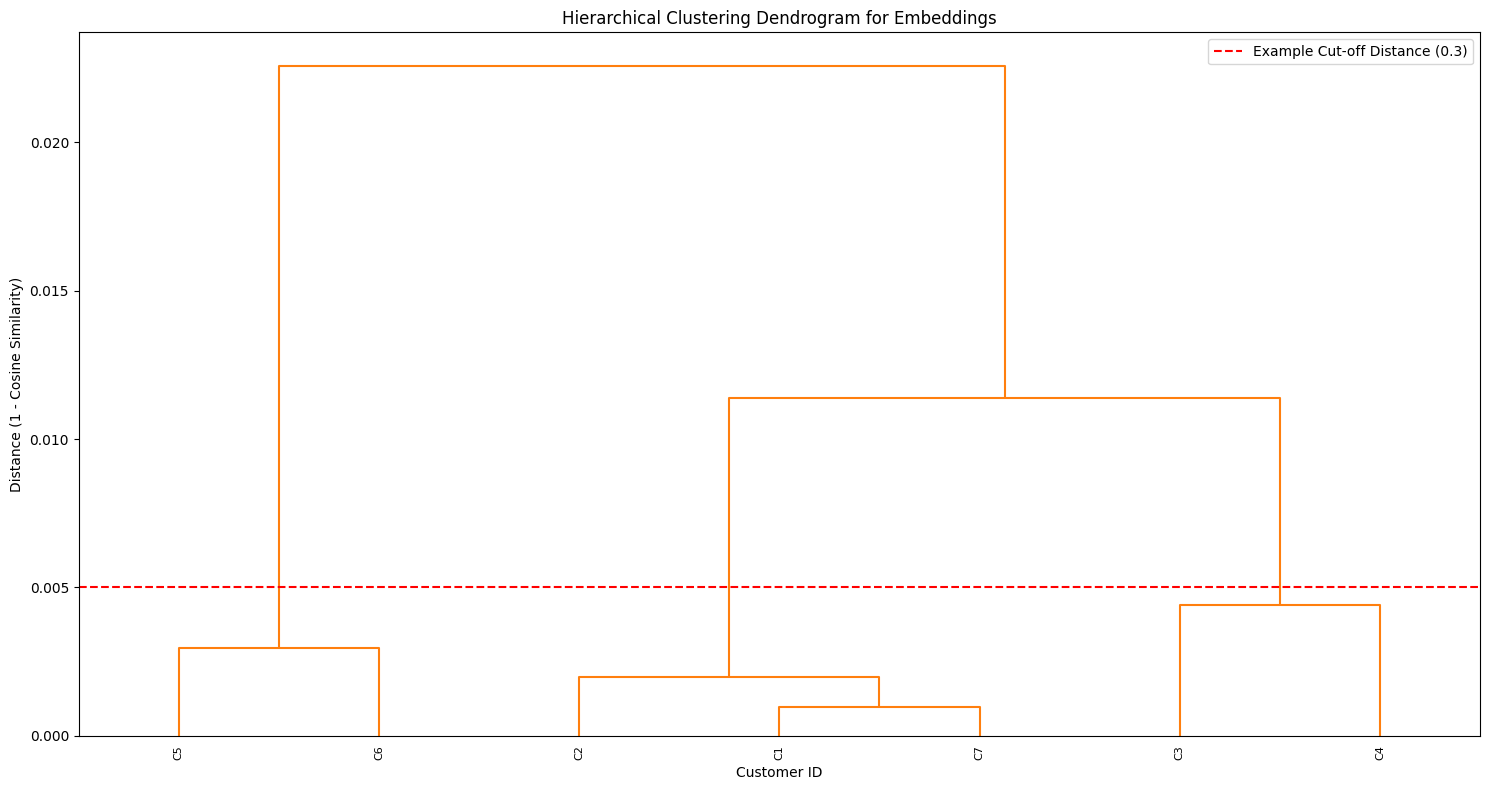


Clusters formed at distance threshold 0.005:
Cluster 1: ['C5', 'C6']
Cluster 2: ['C1', 'C2', 'C7']
Cluster 3: ['C3', 'C4']


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
import matplotlib.pyplot as plt

# Calculate cosine similarity matrix (0 to 1, higher is more similar)
print("\nCalculating cosine similarity matrix for embeddings...")
# For very large datasets, sklearn's pairwise can be slow. Faiss or custom batched GPU calculations are better.
# However, for 30k, it might be feasible on CPU.
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Convert similarity to distance (0 to 1, higher is more distant)
distance_matrix_embeddings = 1 - cosine_sim_matrix
# --- FIX: Explicitly set the diagonal to zero ---
np.fill_diagonal(distance_matrix_embeddings, 0)
print("Diagonal of distance matrix set to zero.")

# --- Then use SciPy's hierarchical clustering (as you've learned) ---
condensed_distance_embeddings = squareform(distance_matrix_embeddings)
Z_embeddings = linkage(condensed_distance_embeddings, method='ward') # Or 'average', 'complete'

print("\nLinkage matrix (Z) created successfully.")
print("First 5 rows of Z_embeddings:\n", Z_embeddings[:5])

# --- Plot dendrogram (assuming you have labels, e.g., customer_ids_for_embeddings) ---
# For this example, let's create dummy labels
customer_ids_for_embeddings = [f'C{i+1}' for i in range(embeddings_array.shape[0])]

plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram for Embeddings')
plt.xlabel('Customer ID')
plt.ylabel('Distance (1 - Cosine Similarity)')

dendrogram(
    Z_embeddings,
    labels=customer_ids_for_embeddings,
    leaf_rotation=90.,
    leaf_font_size=8.,
    color_threshold=0.05, # Adjust this based on your dendrogram
    above_threshold_color='blue'
)
plt.axhline(y=0.005, color='r', linestyle='--', label='Example Cut-off Distance (0.3)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: Extract Clusters at a Specific Threshold ---
max_d = 0.005 # Example threshold
clusters_embeddings = fcluster(Z_embeddings, max_d, criterion='distance')

print(f"\nClusters formed at distance threshold {max_d}:")
for cluster_id in sorted(np.unique(clusters_embeddings)):
    cluster_members = [customer_ids_for_embeddings[i] for i, cid in enumerate(clusters_embeddings) if cid == cluster_id]
    print(f"Cluster {cluster_id}: {cluster_members}")


---------------------------------------------------------------------------------
EMBEDDINGS ON WHOLE SENTENCE using paraphrase-multilingual-MiniLM-L12-v2


In [ ]:
import pandas as pd
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from collections import defaultdict
from tqdm import tqdm
import os
import json

# === Load and Preprocess ===
df = pd.read_csv('D:/ML/grok_adddress_parser/grok_address_parser-env/clustering_test_subset_extended.csv')
df.rename(columns={'test_id': 'customer_id'}, inplace=True)

columns_to_merge = [
    'house_number', 'plot_number', 'road_details', 'locality',
    'area', 'locality2', 'village'
]

# Combine fields into a structured string
df['address_extract'] = df[columns_to_merge].fillna('').apply(lambda row: ', '.join(filter(None, row)), axis=1)
df['address_extract'] = df['address_extract'].str.replace(r'\bdelhi\b', '', case=False, regex=True).str.strip(', ').str.strip()

# Fill missing locality values for grouping
df['locality'] = df['locality'].fillna('unknown').str.lower().str.strip()

# === Load Embedding Model ===
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
#intfloat/multilingual-e5-small


In [ ]:
# === Group by Locality ===
locality_groups = df.groupby('locality')
locality_faiss_indices = {}
cluster_db = []

for locality, group in locality_groups:
    print(f"Processing locality: {locality} | Records: {len(group)}")

    addresses = group['address_extract'].tolist()
    customer_ids = group['customer_id'].tolist()

    # Embed and normalize with progress bar
    embeddings = np.vstack([model.encode(addr, normalize_embeddings=True) for addr in tqdm(addresses, desc=f"Embedding {locality}")])

    # Create FAISS index
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)  # cosine similarity
    index.add(embeddings)

    # Perform similarity search
    similarity_threshold = 0.95
    k = 10
    _, indices = index.search(embeddings, k)

    visited = set()
    locality_clusters = []

    for i, neighbors in enumerate(indices):
        if customer_ids[i] in visited:
            continue

        cluster = set()
        for j in neighbors:
            if j == -1:
                continue
            sim = np.dot(embeddings[i], embeddings[j])
            if sim >= similarity_threshold:
                cluster.add(customer_ids[j])
                visited.add(customer_ids[j])

        if cluster:
            locality_clusters.append({
                "cluster_id": f"{locality[:5]}_{i}",
                "locality": locality,
                "canonical_address": addresses[i],
                "customer_ids": list(cluster)
            })

    cluster_db.extend(locality_clusters)
    locality_faiss_indices[locality] = index  # optional if you want to reuse

# === Save Cluster Output ===
os.makedirs("cluster_output", exist_ok=True)
pd.DataFrame(cluster_db).to_json("cluster_output/clusters.json", orient="records", indent=2)

print(f"Total clusters formed: {len(cluster_db)}")

In [1]:
from collections import Counter
import pandas as pd
df=pd.read_csv("D:/ML/grok_adddress_parser/grok_address_parser-env/d1_structured_parsed.csv")
# For example, assume addresses are in df["address"]
columns_to_merge=['LOCALITY','LOCALITY2','ROAD_DETAILS','AREA','LANDMARK','VILLAGE']
df['address_extract'] = df[columns_to_merge].fillna('').apply(lambda row: ', '.join(filter(None, row)), axis=1)

tokens = [tok for addr in df['address_extract'] for tok in addr.split()]
common_tokens = Counter(tokens).most_common(100)
for token, freq in common_tokens:
    if token.isalpha() and freq > 50:
        print(token)
        

near
laxmi
nagar
gali
number
mandawali
shakarpur
west
mandir
pandav
delhi
fazalpur
vinod
extension
road
patpar
indra
prastha
guru
ganesh
park
pur
ganj
ram
school
vihar
main
angad
lalita
gazi
opposite
preet
madhu
village
dass
kunj
colony
chander
east
krishna
chowk
railway
ramesh
dairy
masjid
mother
market
j
shiv
durga
wali
mangal
back
behind
shankar
hanuman
public
side
joshi
gurudwara
by
mohalla
nanak
ka
bazar
krishan


In [2]:
import pandas as pd
import re

def extract_clean_tokens(df, columns):
    unique_tokens = set()

    for col in columns:
        for val in df[col].dropna():
            if isinstance(val, str):
                # Extract words only (skip numbers and special characters)
                tokens = re.findall(r'\b[a-zA-Z]+\b', val)
                unique_tokens.update([token.lower() for token in tokens])  # normalize to lowercase

    return sorted(unique_tokens)

# Example usage
columns = ['ROAD_DETAILS', 'APARTMENT',
           'LANDMARK', 'LOCALITY', 'AREA', 'LOCALITY2', 'VILLAGE']

# Assuming you have read your CSV as `df`
# df = pd.read_csv("your_file.csv")
clean_tokens = extract_clean_tokens(df, columns)

print(f"🧼 Total unique clean tokens: {len(clean_tokens)}")
print(clean_tokens[:100])  # Preview first 50


🧼 Total unique clean tokens: 10585
['a', 'aa', 'aachar', 'aadar', 'aadarsh', 'aadersh', 'aaditya', 'aagarwal', 'aahuja', 'aakash', 'aakashar', 'aakriti', 'aakrriti', 'aalaha', 'aamar', 'aamarpali', 'aanar', 'aaprtment', 'aapt', 'aas', 'aasa', 'aasha', 'aashan', 'aashirvad', 'aashirwad', 'aashram', 'aata', 'ab', 'abad', 'abadi', 'abadram', 'abb', 'abbdula', 'abbdulla', 'abc', 'abcd', 'abddulla', 'abdekar', 'abdul', 'abdula', 'abdulah', 'abdulha', 'abdulhha', 'abdulla', 'abdullaah', 'abdullah', 'abdullaha', 'abdullh', 'abdullha', 'abetker', 'abfullah', 'abha', 'abhdulla', 'abmdekar', 'abodi', 'about', 'above', 'abp', 'abrol', 'abv', 'ac', 'academy', 'accociate', 'account', 'acd', 'acha', 'achar', 'acharya', 'achhar', 'achid', 'achivers', 'achool', 'acmp', 'acxar', 'ad', 'ada', 'adan', 'adarash', 'adaresh', 'adars', 'adarsh', 'adarshbalbhartipublic', 'adarshpublice', 'add', 'adda', 'additi', 'address', 'adersh', 'adesh', 'adh', 'adhar', 'adharash', 'adharshila', 'adhikari', 'adhikunj', 'a

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
import numpy as np

# Sample list of tokens (replace this with your 20k list)

# Simulate frequencies (replace with actual token counts)
token_counts = Counter({
    'ambedkar': 100,
    'ambdekar': 2,
    'ambdkar': 3,
    'ambedakr': 5,
    'aa': 20,
    'i': 30,
    'j': 25,
    'o': 22,
    'xyz': 1
})

def is_safe_token(token):
    return len(token) <= 2 and token.isalnum()

safe_tokens = set([t for t in clean_tokens if is_safe_token(t)])
correctable_tokens = [t for t in clean_tokens if t not in safe_tokens]

all_tokens = correctable_tokens + list(safe_tokens)

# Load SBERT multilingual embedding model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Generate embeddings
embeddings = model.encode(correctable_tokens, batch_size=32, show_progress_bar=True)

# Cluster semantically similar tokens
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0)
labels = clustering.fit_predict(embeddings)

# Group tokens by cluster
clusters = {}
for token, label in zip(correctable_tokens, labels):
    clusters.setdefault(label, []).append(token)

# Map tokens in each cluster to most frequent one
replacement_map = {}
for group in clusters.values():
    representative = max(group, key=lambda w: token_counts[w])
    for token in group:
        replacement_map[token] = representative

# Identity mappings for safe tokens
for token in safe_tokens:
    replacement_map[token] = token

# Output corrected mapping
mapping_df = pd.DataFrame({
    'original_token': all_tokens,
    'corrected_token': [replacement_map[tok] for tok in all_tokens]
})

# Optional: Save mapping
mapping_df.to_csv("token_corrections.csv", index=False)
print(mapping_df.head(10))


In [3]:
import re
import pandas as pd
import numpy as np
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances

# ── Step 1: Load Data ───────────────────────────────────────────────────────────
df = pd.read_csv("D:/ML/grok_adddress_parser/grok_address_parser-env/exp1.csv")
df = df.iloc[:20000]
ADDRESS_COL = "CUSTADDR"

# ── Step 2: Extract “meaningful” tokens (only letters, length>2) ────────────────
def extract_meaningful_tokens(text):
    text = re.sub(r'\b\d{6}\b', '', text.lower())        # drop pin
    return re.findall(r'\b[a-zA-Z]{3,}\b', text)         # only 3+ letter words

df['tokens'] = df[ADDRESS_COL].map(extract_meaningful_tokens)

# ── Step 3: Build vocabulary + counts ─────────────────────────────────────────
all_tokens   = [tok for toks in df['tokens'] for tok in toks]
token_counts = Counter(all_tokens)
unique_tokens = list(token_counts.keys())

# ── Step 4: Embed tokens with SBERT ───────────────────────────────────────────
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "ai4bharat/indic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

embeddings = get_embedding(unique_tokens)

# ── Step 5: Compute Cosine‑distance matrix ─────────────────────────────────────
D = cosine_distances(embeddings)  # shape (V, V)

# ── Step 6: Agglomerative clustering on precomputed distances ─────────────────
clusterer = AgglomerativeClustering(
    n_clusters=None,
    metric='precomputed',       # <- replaces 'affinity'
    linkage='average',
    distance_threshold=0.3
)

labels = clusterer.fit_predict(D)

# ── Step 7: Build replacement map (most‑frequent in each cluster) ────────────
clusters = {}
for tok, lab in zip(unique_tokens, labels):
    clusters.setdefault(lab, []).append(tok)

replacement_map = {}
for group in clusters.values():
    # pick the *most frequent* token as canonical
    canonical = max(group, key=lambda t: token_counts[t])
    for t in group:
        replacement_map[t] = canonical

# ── Step 8: Apply replacements back into the full address ────────────────────
def correct_address(text, correction_map):
    words = text.split()
    out = []
    for w in words:
        cleaned = re.sub(r'[^a-zA-Z]', '', w.lower())
        if cleaned in correction_map and correction_map[cleaned] != cleaned:
            # debug print to confirm replacements
            print(f"🔁 {cleaned} → {correction_map[cleaned]}")
            # preserve original delimiters/punctuation
            new = re.sub(cleaned, correction_map[cleaned], w, flags=re.IGNORECASE)
            out.append(new)
        else:
            out.append(w)
    return " ".join(out)

df['corrected_address'] = df[ADDRESS_COL].map(lambda txt: correct_address(txt, replacement_map))

# ── Step 9: Export your spell‑check map & inspect ──────────────────────────────
corrections_df = (
    pd.DataFrame([
        {'original_token': o, 'corrected_token': c}
        for o, c in replacement_map.items()
        if o != c
    ])
    .sort_values('corrected_token')
)
print("=== Top 20 Corrections ===")
print(corrections_df.head(20))
corrections_df.to_csv("token_spellcheck_map.csv", index=False)

# ── Step 10: Inspect sample before/after ──────────────────────────────────────
print(df[[ADDRESS_COL, 'corrected_address']].head(10))


ValueError: Converting from SentencePiece and Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast converters: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenizer', 'Qwen2Tokenizer', 'RealmTokenizer', 'ReformerTokenizer', 'RemBertTokenizer', 'RetriBertTokenizer', 'RobertaTokenizer', 'RoFormerTokenizer', 'SeamlessM4TTokenizer', 'SqueezeBertTokenizer', 'T5Tokenizer', 'UdopTokenizer', 'WhisperTokenizer', 'XLMRobertaTokenizer', 'XLNetTokenizer', 'SplinterTokenizer', 'XGLMTokenizer', 'LlamaTokenizer', 'CodeLlamaTokenizer', 'GemmaTokenizer', 'Phi3Tokenizer']

In [29]:
def correct_address(text, correction_map):
    words = text.split()
    corrected_words = []
    for word in words:
        # Normalize for matching (lowercase, strip punctuations)
        cleaned = re.sub(r'[^a-zA-Z]', '', word.lower())
        # If word matches correction, replace with canonical token (preserve casing)
        if cleaned in correction_map:
            corrected = correction_map[cleaned]
            # Maintain original punctuation
            corrected_words.append(word.lower().replace(cleaned, corrected))
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

df['corrected_address'] = df[address_col].apply(lambda x: correct_address(x, replacement_map))


In [30]:
# Create a DataFrame of corrections
corrections_df = pd.DataFrame([
    {'original_token': orig, 'corrected_token': corrected}
    for orig, corrected in replacement_map.items()
    if orig != corrected  # Only show where correction actually happened
])

# Optional: Sort by corrected_token or frequency
corrections_df = corrections_df.sort_values(by='corrected_token')

# Show top 20 corrections
print(corrections_df.head(20))

# Save for inspection
corrections_df.to_csv("token_spellcheck_map.csv", index=False)


   original_token corrected_token
70          janta           anagd
37          nanak           ankur
39          gokal           ankur
38         govind           ankur
40         gautam           ankur
41          janki           ankur
9          patpar           basti
71         bhatra           bhati
45      gokulpuri        brijpuri
46       rajdhani        brijpuri
20          pusta         chauhan
24            tek            dass
22            som            dass
23       dayanand            dass
18          param           durga
19         mukand           durga
44          santu          gandhi
54       gokalpur       gokalpuri
27         makund          gujran
28          kallu          gujran
